# Inverse distance weighting - Crimes Dataset

https://photutils.readthedocs.io/en/stable/api/photutils.utils.ShepardIDWInterpolator.html

https://pareekshithkatti.medium.com/inverse-distance-weighting-interpolation-in-python-68351fb612d2

## Importing packages and loading necessary datasets

In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ipdw
from sklearn.model_selection import train_test_split, GridSearchCV
from photutils.utils import ShepardIDWInterpolator
import time
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

In [18]:
crimes_df = pd.read_csv("crimes_processed_vehicle.csv")

In [19]:
display(crimes_df)

Latitude  Longitude         n  location_id
0      41.644590 -87.615880  0.000000            1
1      41.647037 -87.616647  0.000000            2
2      41.647039 -87.616098  0.693147            3
3      41.647180 -87.544241  0.000000            4
4      41.647716 -87.542811  0.000000            5
...          ...        ...       ...          ...
25449  42.022526 -87.672401  0.000000        25450
25450  42.022529 -87.666324  0.000000        25451
25451  42.022535 -87.673398  0.693147        25452
25452  42.022536 -87.673711  0.000000        25453
25453  42.022548 -87.676139  0.000000        25454

[25454 rows x 4 columns]

## Splitting Data

In [20]:
# Convert columns to numpy arrays
observed_location_columns_crimes = ['Latitude', 'Longitude']
observed_values_column_crimes = 'n'
observed_locations_crimes = crimes_df[observed_location_columns_crimes].values
observed_values_crimes = crimes_df[observed_values_column_crimes].values

In [21]:
X_train_crimes, X_test_crimes, y_train_crimes, y_test_crimes = train_test_split(observed_locations_crimes,
                                                                            observed_values_crimes, test_size=0.2, random_state=0)
print(f"X_train_meuse.shape: {X_train_crimes.shape}")
print(f"X_test_meuse.shape:  {X_test_crimes.shape}")
print(f"y_train_meuse.shape: {y_train_crimes.shape}")
print(f"y_test_meuse.shape:  {y_test_crimes.shape}")

X_train_meuse.shape: (20363, 2)
X_test_meuse.shape:  (5091, 2)
y_train_meuse.shape: (20363,)
y_test_meuse.shape:  (5091,)


## K-Fold Cross Validation

In [22]:
# Using list comprehension
x_data_train = [inner_list[0] for inner_list in X_train_crimes]
y_data_train = [inner_list[1] for inner_list in X_train_crimes]

In [56]:
cv_data = pd.DataFrame({
    'X': x_data_train,
    'Y': y_data_train,
    'Z': y_train_crimes
})

# Initialize an empty dictionary
cv_score_list = {}
powers_list = [1,2,3,4,5,6,7,8,9,10,11,12,15,20]
#For each possible theoratical model, conduct K-Fold CV
for power in powers_list:
    
    
    # Define K-Fold cross-validation
    kfold = KFold(n_splits=5, shuffle=True, random_state=42)

    # Initialize lists to store cross-validation results
    cv_scores_mae = []
    cv_scores_rmse = []
    cv_scores_mape = []

    # Perform K-Fold cross-validation
    for train_index, test_index in kfold.split(cv_data):
        train_data = cv_data.iloc[train_index]
        test_data = cv_data.iloc[test_index]
        
        combined_array_train = np.array([list(pair) for pair in zip(train_data['X'], train_data['Y'])])
        idw_model = ShepardIDWInterpolator(combined_array_train, train_data['Z'])
        
        # Predict at test locations
        combined_array_test = np.array([list(pair) for pair in zip(test_data['X'], test_data['Y'])])
        z_pred_train = idw_model.__call__(combined_array_test, power = power)
        
        # Calculate Metrics and append the validation score for each split into cv_scores_metric
        rmse = np.sqrt(mean_squared_error(test_data['Z'], z_pred_train))
        mae = mean_absolute_error(test_data['Z'], z_pred_train)
        mape = mean_absolute_percentage_error(test_data['Z'], z_pred_train)
        cv_scores_mae.append(mae)
        cv_scores_rmse.append(rmse)
        cv_scores_mape.append(mape)
        
    # Calulcate mean CV score for all splits for each metric    
    mean_validation_score_mae = np.mean(cv_scores_mae)
    mean_validation_score_rmse = np.mean(cv_scores_rmse)
    mean_validation_score_mape = np.mean(cv_scores_mape)
    
    # Store the mean CV score for each metric for this iteration of theoratical model chosen
    cv_score_list[power] = {
        "CV Score MAE" : mean_validation_score_mae,
        "CV Score RMSE" : mean_validation_score_rmse,
        "CV Score MAPE" : mean_validation_score_mape
    }

# Now there is a dictionary of mean CV scores for 3 different metrics for each possible model 
display(pd.DataFrame(cv_score_list))

# Find the model with the smallest mean CV score for each metric
# Initialize a dictionary to track the smallest scores and corresponding models
smallest_scores = {
    "CV Score MAE": {"value": float('inf'), "power": None},
    "CV Score RMSE": {"value": float('inf'), "power": None},
    "CV Score MAPE": {"value": float('inf'), "power": None}
}

# Iterate through each model's scores in the dictionary
for power, scores in cv_score_list.items():
    for score_type in scores:
        if scores[score_type] < smallest_scores[score_type]["value"]:
            smallest_scores[score_type]["value"] = scores[score_type]
            smallest_scores[score_type]["power"] = power

# Display the results
for score_type, info in smallest_scores.items():
    print(f"The smallest {score_type} is {info['value']}, found in power of {info['power']}.")

1             2             3             4   \
CV Score MAE   1.890086e-01  1.895941e-01  1.901438e-01  1.905492e-01   
CV Score RMSE  3.570113e-01  3.820559e-01  3.958389e-01  4.045775e-01   
CV Score MAPE  4.218430e+14  4.194107e+14  4.188884e+14  4.187452e+14   

                         5             6             7             8   \
CV Score MAE   1.908134e-01  1.910032e-01  1.911529e-01  1.912877e-01   
CV Score RMSE  4.106752e-01  4.151543e-01  4.185700e-01  4.212566e-01   
CV Score MAPE  4.185828e+14  4.183727e+14  4.181447e+14  4.179239e+14   

                         9             10            11            12  \
CV Score MAE   1.913973e-01  1.914933e-01  1.915778e-01  1.916533e-01   
CV Score RMSE  4.234262e-01  4.252185e-01  4.267279e-01  4.280198e-01   
CV Score MAPE  4.177244e+14  4.175528e+14  4.174103e+14  4.172952e+14   

                         15            20  
CV Score MAE   1.918497e-01  1.921043e-01  
CV Score RMSE  4.309967e-01  4.342136e-01  
CV Score MAPE  4.170836e+14  4.169991e+14

The smallest CV Score MAE is 0.1890086079997324, found in power of 1.
The smallest CV Score RMSE is 0.35701129924421193, found in power of 1.
The smallest CV Score MAPE is 416999136796385.75, found in power of 20.


In [57]:
cv_results = pd.DataFrame(cv_score_list).T
plt.plot(powers_list, cv_results["CV Score RMSE"], color='darkorange', label='RMSE score')
plt.plot(powers_list, cv_results["CV Score MAE"], color='darkblue', label='MAE score')
#plt.plot(n_neighbors_list, cv_results["CV Score MAPE"], color='darkgreen', label='MAPE score')
plt.xlabel('Power Value')
plt.ylabel('Score')
#plt.yscale('log')
plt.legend()
plt.show()

In [58]:
cv_results = pd.DataFrame(cv_score_list).T
plt.plot(powers_list, cv_results["CV Score MAPE"], color='darkgreen', label='MAPE score')
plt.xlabel('Power Value')
plt.ylabel('Score')
#plt.yscale('log')
plt.legend()
plt.show()

### n_neighbors

In [50]:
cv_data = pd.DataFrame({
    'X': x_data_train,
    'Y': y_data_train,
    'Z': y_train_crimes
})

# Initialize an empty dictionary
cv_score_list = {}

# For each possible number of neighbors, conduct K-Fold CV
n_neighbors_list = [8, 10, 12, 24, 48, 96, 120, 150, 180, 200, 250, 2000, 2500]
for n_neighbors in n_neighbors_list:
    
    # Define K-Fold cross-validation
    kfold = KFold(n_splits=5, shuffle=True, random_state=42)

    # Initialize lists to store cross-validation results
    cv_scores_mae = []
    cv_scores_rmse = []
    cv_scores_mape = []

    # Perform K-Fold cross-validation
    for train_index, test_index in kfold.split(cv_data):
        train_data = cv_data.iloc[train_index]
        test_data = cv_data.iloc[test_index]
        
        combined_array_train = np.array([list(pair) for pair in zip(train_data['X'], train_data['Y'])])
        idw_model = ShepardIDWInterpolator(combined_array_train, train_data['Z'])
        
        # Predict at test locations
        combined_array_test = np.array([list(pair) for pair in zip(test_data['X'], test_data['Y'])])
        z_pred_train = idw_model.__call__(combined_array_test, power = 1, n_neighbors = n_neighbors)
        
        # Calculate Metrics
        rmse = np.sqrt(mean_squared_error(test_data['Z'], z_pred_train))
        mae = mean_absolute_error(test_data['Z'], z_pred_train)
        mape = mean_absolute_percentage_error(test_data['Z'], z_pred_train)
        cv_scores_mae.append(mae)
        cv_scores_rmse.append(rmse)
        cv_scores_mape.append(mape)
    
   
    # Calculate mean CV score for all splits for each metric    
    mean_validation_score_mae = np.mean(cv_scores_mae)
    mean_validation_score_rmse = np.mean(cv_scores_rmse)
    mean_validation_score_mape = np.mean(cv_scores_mape)
    
    # Store the mean CV score for each metric for this iteration of n_neighbors chosen
    cv_score_list[n_neighbors] = {
        "CV Score MAE": mean_validation_score_mae,
        "CV Score RMSE": mean_validation_score_rmse,
        "CV Score MAPE": mean_validation_score_mape
    }

# Display the results
display(pd.DataFrame(cv_score_list))  # Transposed for better readability

# Find the model with the smallest mean CV score for each metric
# Adjusted to find the best `n_neighbors`
smallest_scores = {
    "CV Score MAE": {"value": float('inf'), "n_neighbors": None},
    "CV Score RMSE": {"value": float('inf'), "n_neighbors": None},
    "CV Score MAPE": {"value": float('inf'), "n_neighbors": None}
}

for n_neighbors, scores in cv_score_list.items():
    for score_type in scores:
        if scores[score_type] < smallest_scores[score_type]["value"]:
            smallest_scores[score_type]["value"] = scores[score_type]
            smallest_scores[score_type]["n_neighbors"] = n_neighbors

# Display the results
for score_type, info in smallest_scores.items():
    print(f"The smallest {score_type} is {info['value']}, found with {info['n_neighbors']} neighbors.")


8             10            12            24    \
CV Score MAE   1.890086e-01  1.888670e-01  1.887872e-01  1.891672e-01   
CV Score RMSE  3.570113e-01  3.527660e-01  3.496605e-01  3.413798e-01   
CV Score MAPE  4.218430e+14  4.218073e+14  4.219789e+14  4.234295e+14   

                       48            96            120           150   \
CV Score MAE   1.895787e-01  1.899435e-01  1.901487e-01  1.902873e-01   
CV Score RMSE  3.352562e-01  3.310529e-01  3.299638e-01  3.290103e-01   
CV Score MAPE  4.252579e+14  4.261654e+14  4.269065e+14  4.272441e+14   

                       180           200           250           2000  \
CV Score MAE   1.904985e-01  1.905396e-01  1.907010e-01  1.930181e-01   
CV Score RMSE  3.283517e-01  3.279826e-01  3.272458e-01  3.244045e-01   
CV Score MAPE  4.280020e+14  4.279981e+14  4.283557e+14  4.340952e+14   

                       2500  
CV Score MAE   1.933309e-01  
CV Score RMSE  3.243706e-01  
CV Score MAPE  4.348410e+14

The smallest CV Score MAE is 0.18878723844339956, found with 12 neighbors.
The smallest CV Score RMSE is 0.3243705562711545, found with 2500 neighbors.
The smallest CV Score MAPE is 421807298437723.1, found with 10 neighbors.


In [51]:
cv_results = pd.DataFrame(cv_score_list).T
plt.plot(n_neighbors_list, cv_results["CV Score RMSE"], color='darkorange', label='RMSE score')
plt.plot(n_neighbors_list, cv_results["CV Score MAE"], color='darkblue', label='MAE score')
#plt.plot(n_neighbors_list, cv_results["CV Score MAPE"], color='darkgreen', label='MAPE score')
plt.xlabel('N Neighbors')
plt.ylabel('Score')
#plt.yscale('log')
plt.legend()
plt.show()

In [55]:
cv_results = pd.DataFrame(cv_score_list).T
plt.plot(n_neighbors_list, cv_results["CV Score MAPE"], color='darkgreen', label='MAPE score')
plt.xlabel('N Neighbors')
plt.ylabel('Score')
#plt.yscale('log')
plt.legend()
plt.show()

We can see that RMSE and MAPE do not seem to be robust metrics here, and thus the hyperparameter is chosen based on MAE.

## Hyperparameter selection

As we can see, power = 1 and n_neighbors = 12 would be the most optimal option.

## Evaluation of Model (Testing Chosen model)

Is it supposed to refit model on all the train data then test on test data?

### Performance Metrics of Model

In [59]:
# Using list comprehension
x_data_train = [inner_list[0] for inner_list in X_train_crimes]
y_data_train = [inner_list[1] for inner_list in X_train_crimes]

train_data = pd.DataFrame({
    'X': x_data_train,
    'Y': y_data_train,
    'Z': y_train_crimes
})

x_data_test = [inner_list[0] for inner_list in X_test_crimes]
y_data_test = [inner_list[1] for inner_list in X_test_crimes]

test_data = pd.DataFrame({
    'X': x_data_test,
    'Y': y_data_test,
    'Z': y_test_crimes
})

eval_combined_array_coordinates = np.array([list(pair) for pair in zip(train_data['X'], train_data['Y'])])
idw_model = ShepardIDWInterpolator(eval_combined_array_coordinates, train_data['Z'])

 # Predict at test locations
eval_combined_array_test = np.array([list(pair) for pair in zip(test_data['X'], test_data['Y'])])
z_pred_test = idw_model.__call__(eval_combined_array_test, power = 1, n_neighbors = 12)

rmse = np.sqrt(mean_squared_error(test_data['Z'], z_pred_test))
mae = mean_absolute_error(test_data['Z'], z_pred_test)
mape = mean_absolute_percentage_error(test_data['Z'], z_pred_test)

print("MAE:", mae)
print("RMSE:", rmse)
print("MAPE:", mape)

MAE: 0.18743848910464242
RMSE: 0.34811039657757814
MAPE: 417381830482672.6


### Plotting Spatial Interpolation of entire area with Model

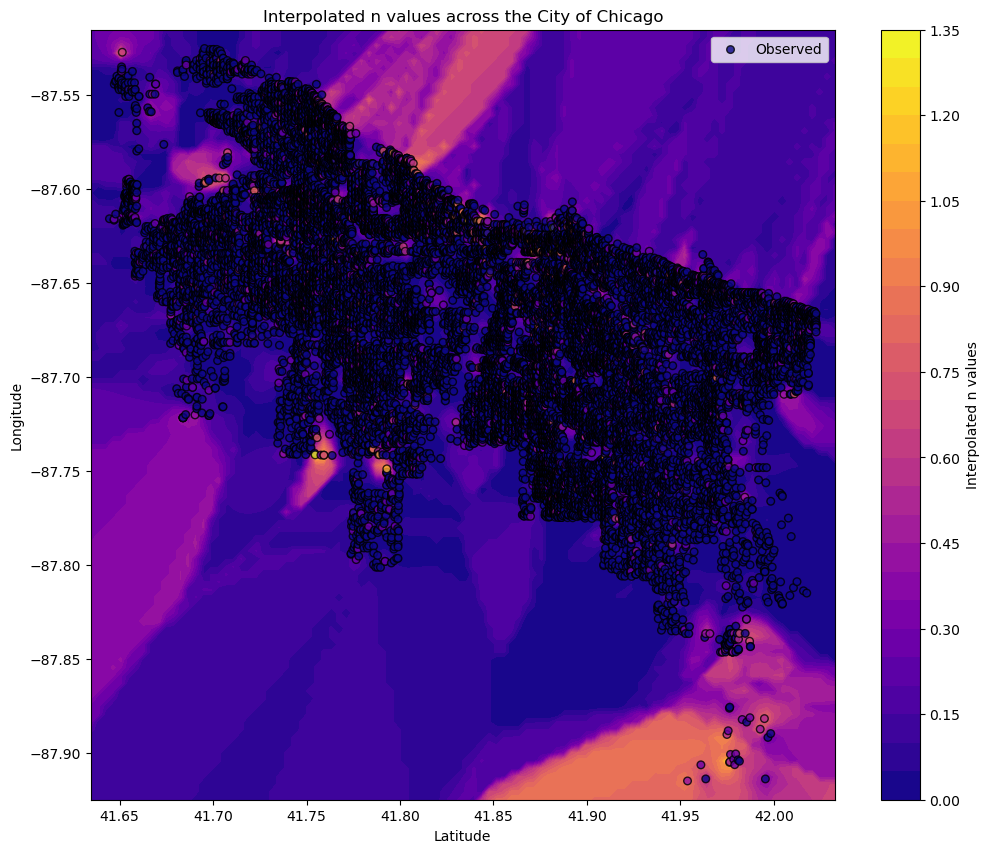

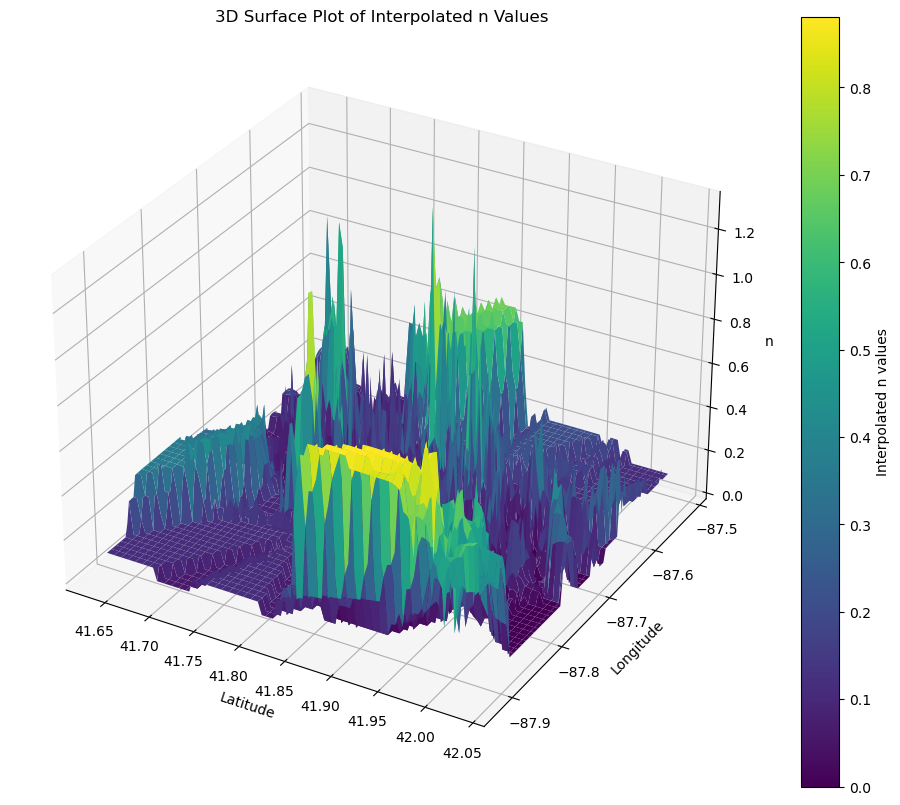

Spatial Interpolation Computation Time: 0.22 seconds


In [60]:
# Using full set: Convert columns to numpy arrays
observed_location_columns_crimes = ['Latitude', 'Longitude']
observed_values_column_crimes = 'n'
observed_locations_crimes = crimes_df[observed_location_columns_crimes].values
observed_values_crimes = crimes_df[observed_values_column_crimes].values

# Initialize IDW model
idw_model = ShepardIDWInterpolator(observed_locations_crimes, observed_values_crimes)

# Start timing spatial interpolation
start_time_interpolation = time.time()

buffer = 0.01
x_min, x_max = observed_locations_crimes[:, 0].min() - buffer, observed_locations_crimes[:, 0].max() + buffer
y_min, y_max = observed_locations_crimes[:, 1].min() - buffer, observed_locations_crimes[:, 1].max() + buffer

x_range = np.linspace(x_min, x_max, 100)
y_range = np.linspace(y_min, y_max, 100)
x_grid, y_grid = np.meshgrid(x_range, y_range)
grid_points = np.c_[x_grid.ravel(), y_grid.ravel()]

# Interpolate values
interpolated_values = idw_model.__call__(grid_points, power = 1, n_neighbors = 12)
z_grid = interpolated_values.reshape(x_grid.shape)

end_time_interpolation = time.time()  # End timing spatial interpolation

fig = plt.figure(figsize=(12, 10))

from mpl_toolkits.mplot3d import Axes3D

plt.contourf(x_grid, y_grid, z_grid, cmap='plasma', levels=30)
plt.colorbar(label='Interpolated n values')
plt.scatter(crimes_df['Latitude'],crimes_df['Longitude'], c=crimes_df['n'], cmap='plasma', edgecolor='k', label='Observed', marker='o', s=30, alpha=0.8)

plt.xlim(x_min, x_max)  # Set x-axis limits
plt.ylim(y_min, y_max)  # Set y-axis limits

plt.xlabel('Latitude')
plt.ylabel('Longitude')
plt.legend()
plt.title('Interpolated n values across the City of Chicago')
plt.show()

fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(x_grid, y_grid, z_grid, cmap='viridis', edgecolor='none')
fig.colorbar(surf, ax=ax, label='Interpolated n values')
ax.set_xlabel('Latitude')
ax.set_ylabel('Longitude')
ax.set_zlabel('n')
ax.set_title('3D Surface Plot of Interpolated n Values')
plt.show()

print(f"Spatial Interpolation Computation Time: {end_time_interpolation - start_time_interpolation:.2f} seconds")
